### Stress Computation of Viscoelasticity

The Kirchoff stress is given by:

$$\mathbf{\tau} = p\mathbf{1} + \mathbb{P}:(\bar{\mathbf{\tau}^e} + \bar{\mathbf{\tau}^v})$$
  
where the pressure $p$ is computed using the incompressibility assumption and boundary condition.  
The equilibrium ($\bar{\mathbf{\tau}}^e$) and non-equilibrium parts ($\bar{\mathbf{\tau}}^v$) of $\bar{\mathbf{\tau}}$ are functions of the unimodular part of the left Cauchy Green Tensor ($\bar{\mathbf{b}}$) and the elastic left Cauchy Green Tensor ($\mathbf{b}_e$) respectively:
$$\bar{\mathbf{\tau}}^e = \bar{\mathbf{\tau}}^e(\bar{\mathbf{b}})$$
$$\bar{\mathbf{\tau}}^v = \bar{\mathbf{\tau}}^v(\mathbf{b}_e)$$


The elastic left Cauchy Green Tensor serves as the strain-based internal variable. The rate of $\mathbf{b}_e$ is governed by the equation:
$$\dot{\mathbf{b}_e} = [-2\dot{\gamma}\mathbf{N}] \text{  } \mathbf{b}_e^{tr}$$


For each model below, we will provide expressions for $\bar{\mathbf{\tau}}^e$, $\bar{\mathbf{\tau}}^v$ and $\dot{\gamma}$.

### Generating synthetic data

In [2]:
import sys
import os

# Get the python script's directory to import functions
current_dir = os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(current_dir, '../../'))
if grandparent_dir not in sys.path:
    sys.path.append(grandparent_dir)


from synthetic_data import *
from optimize import optimize, evaluate

We generate uniaxial cyclic data using the Bergstrom-Boyce model.

$$\mathbf{\bar{\tau}}^e = 2(C_1 + I_1 C_2)\text{  }\mathbf{\bar{b}} - 2 C_2\text{  }\mathbf{\bar{b}}^2$$
$$\mathbf{\bar{\tau}}^v = 2(C_{1v} + I^e_{1} C_{2v})\text{  }\mathbf{b_e} - 2 C_{2v}\text{  }\mathbf{b_e}^2$$
$$\dot{\gamma} = a_j \left( \frac{\tau_v}{\hat{\tau}} \right)^j$$  

The function used for the stress update of this model can be found in `mat.py` named `umri_su`

In [3]:
np.random.seed(42)
# Identifier to use a Mooney-Rivlin inelastic model for uniaxial
# data with incompressibility assumption (umri)
mat = "umri"

num_branches = 10
power_terms = 10
c1 = np.round(np.random.uniform(0.01, 0.1), 2)
c1_v = [0 for i in range(num_branches)]
c1_v[0] = np.round(np.random.uniform(0.01, 0.1), 2)
c2 = np.round(np.random.uniform(0.01, 0.1), 2)
c2_v = [0 for i in range(num_branches)]
c2_v[0] = np.round(np.random.uniform(0.01, 0.1), 2)
tauhinv = [1e-8 for i in range(num_branches)]
tauhinv[0] = 1
aj = [0 for i in range(num_branches*power_terms)]
aj[2] = np.round(np.random.uniform(30, 300), 2)
params = [c1] + c1_v + [c2] + c2_v + tauhinv + aj

params_names = \
    ['c1'] + [f'c1v{i}' for i in range(1, 1 + num_branches)] + \
    ['c2'] + [f'c2v{i}' for i in range(1, 1 + num_branches)] + \
    [f'tauhinv{i}' for i in range(1, 1 + num_branches)] + \
    [f'a{i}_{j}' for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]

print('###--NON ZERO PARAMETERS--###')

for j in range(len(params)):
    if params[j] > 1e-7:
        print(params_names[j], " :", params[j])

###--NON ZERO PARAMETERS--###
c1  : 0.04
c1v1  : 0.1
c2  : 0.08
c2v1  : 0.06
tauhinv1  : 1
a1_3  : 72.13


/home/masood/Documents/GitHub/msc-thesis-functions/mat.py:627: RuntimeWarning: invalid value encountered in divide
  res = eps_a + dt*gamma_dot*devtau_a/np.sqrt(2)/tau_v - eps_a_tr
/home/masood/Documents/GitHub/msc-thesis-functions/mat.py:630: RuntimeWarning: divide by zero encountered in scalar power
  beta1 = (dt/2/np.sqrt(2))*(tauhinv**3)*sum([aj[j-1]*(j-1)*(tau_v*tauhinv)**(j-3) for
/home/masood/Documents/GitHub/msc-thesis-functions/mat.py:630: RuntimeWarning: invalid value encountered in scalar multiply
  beta1 = (dt/2/np.sqrt(2))*(tauhinv**3)*sum([aj[j-1]*(j-1)*(tau_v*tauhinv)**(j-3) for
/home/masood/Documents/GitHub/msc-thesis-functions/mat.py:632: RuntimeWarning: invalid value encountered in scalar divide
  beta2 = dt*gamma_dot/np.sqrt(2)/tau_v


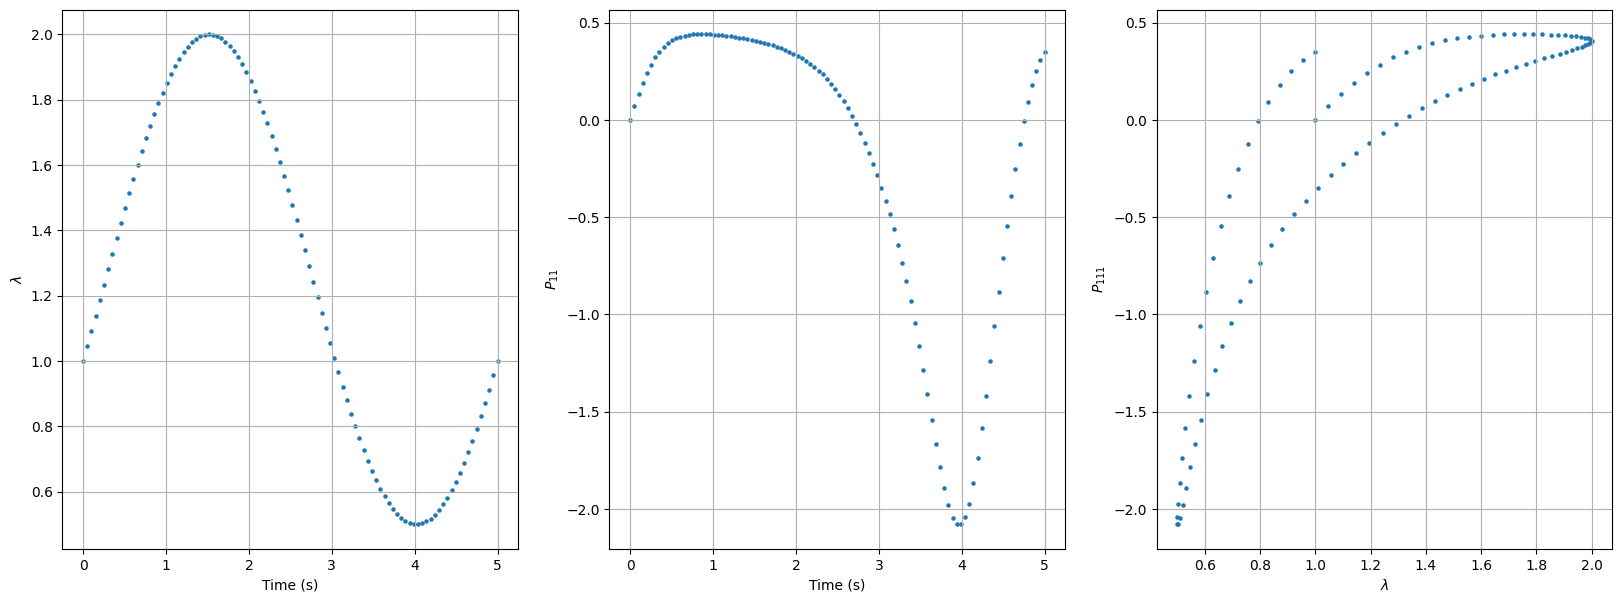

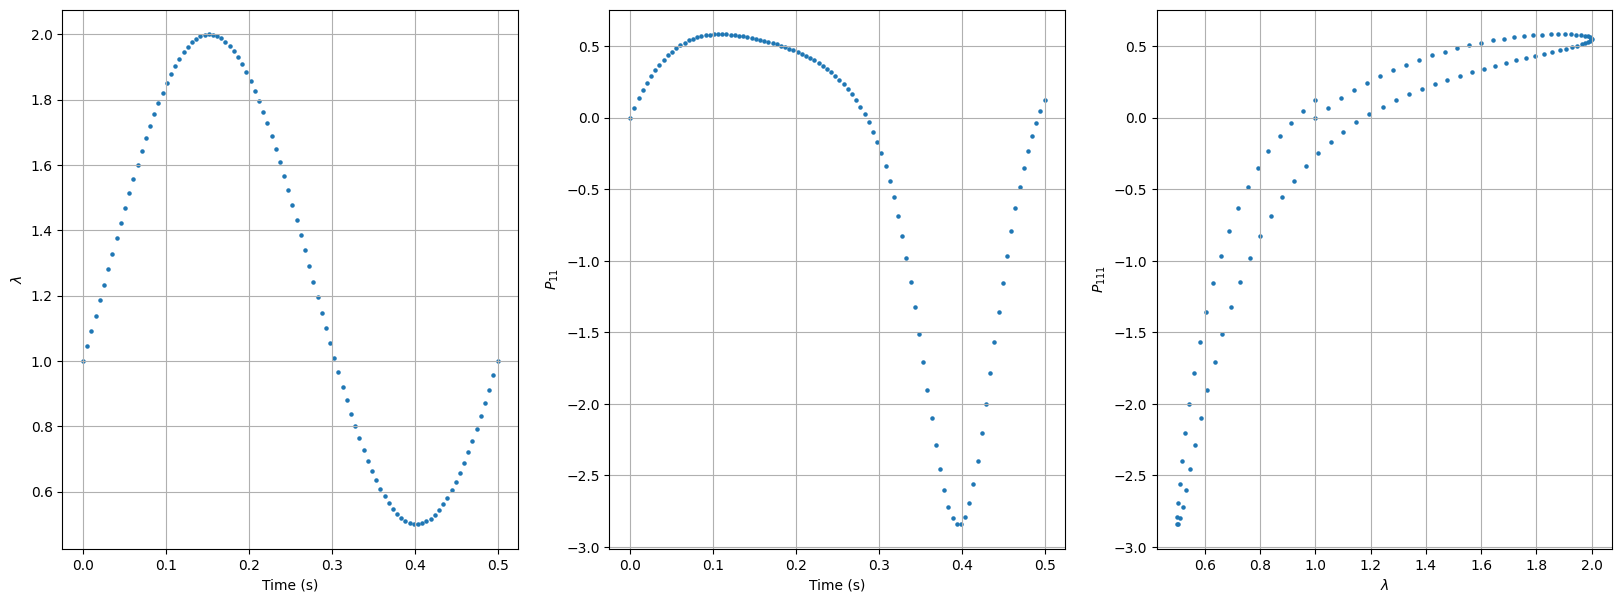

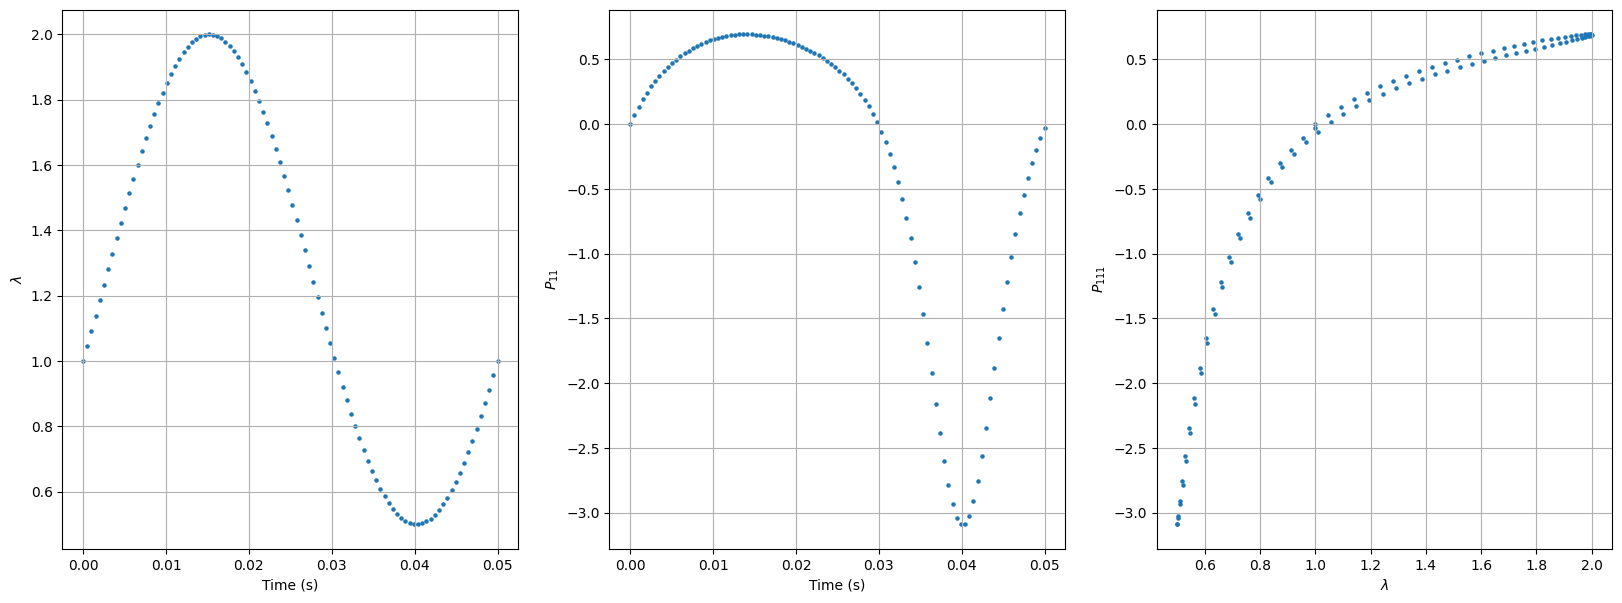

In [3]:
# Generate cylic data (time, true_strain, true_stress)
# for three different frequencies
mdata = []
freqs = [0.2, 2, 20]
for freq in freqs:
    t, stretch = cyclic_loading(max_val=2, min_val=0.5, start=1, freq=freq,
                                cycles = 1, dt = 0.01/freq,
                                plot=False)
    strain = np.log(stretch)
    t, strain, stress = generate_mdata(t, strain, params, mat, plot=False, noise=0)
    mdata.append((t, strain, stress))

    # Plot nominal stress vs stretch
    stretch = np.exp(strain)
    P11 = stress/stretch
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 3, 1)
    plt.scatter(t, stretch, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$\lambda$')
    plt.grid()
    plt.subplot(1, 3, 2)
    plt.scatter(t, P11, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$P_{11}$')
    plt.grid()
    plt.subplot(1, 3, 3)
    plt.scatter(stretch, P11, s = 5)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$P_{11}$')
    plt.grid()

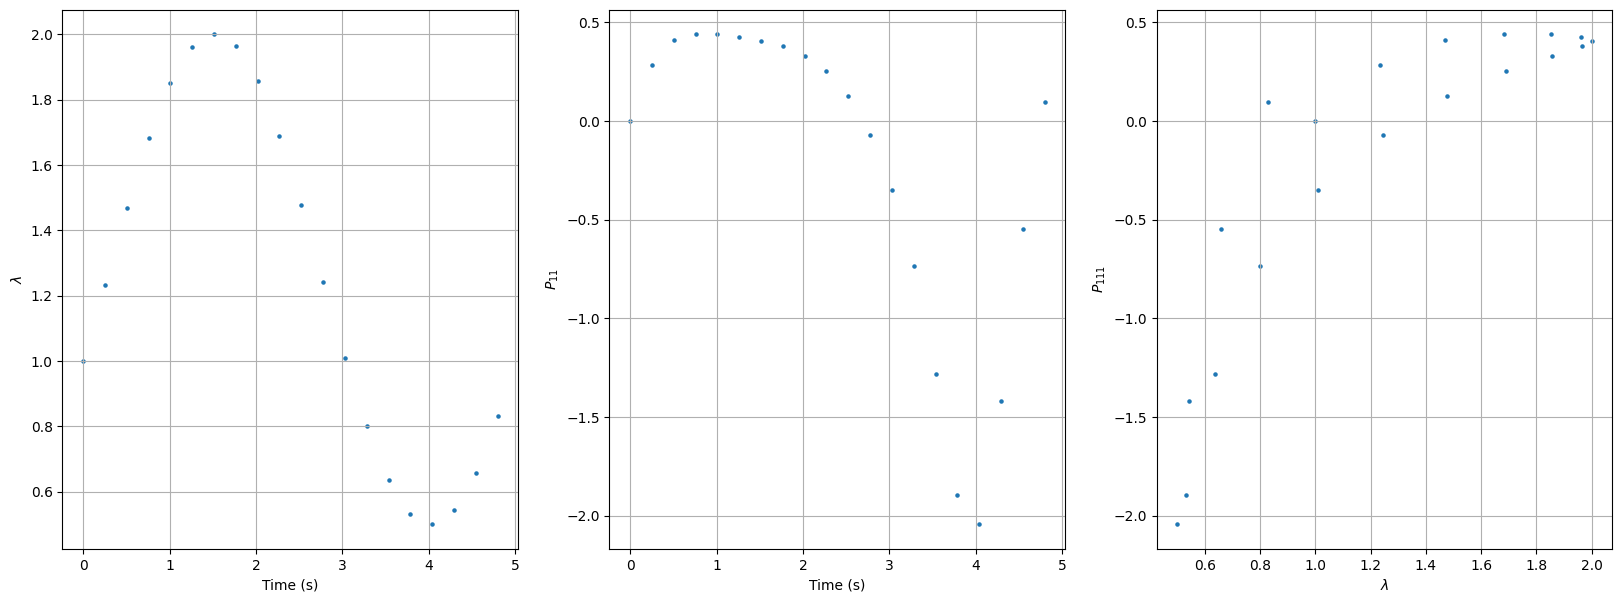

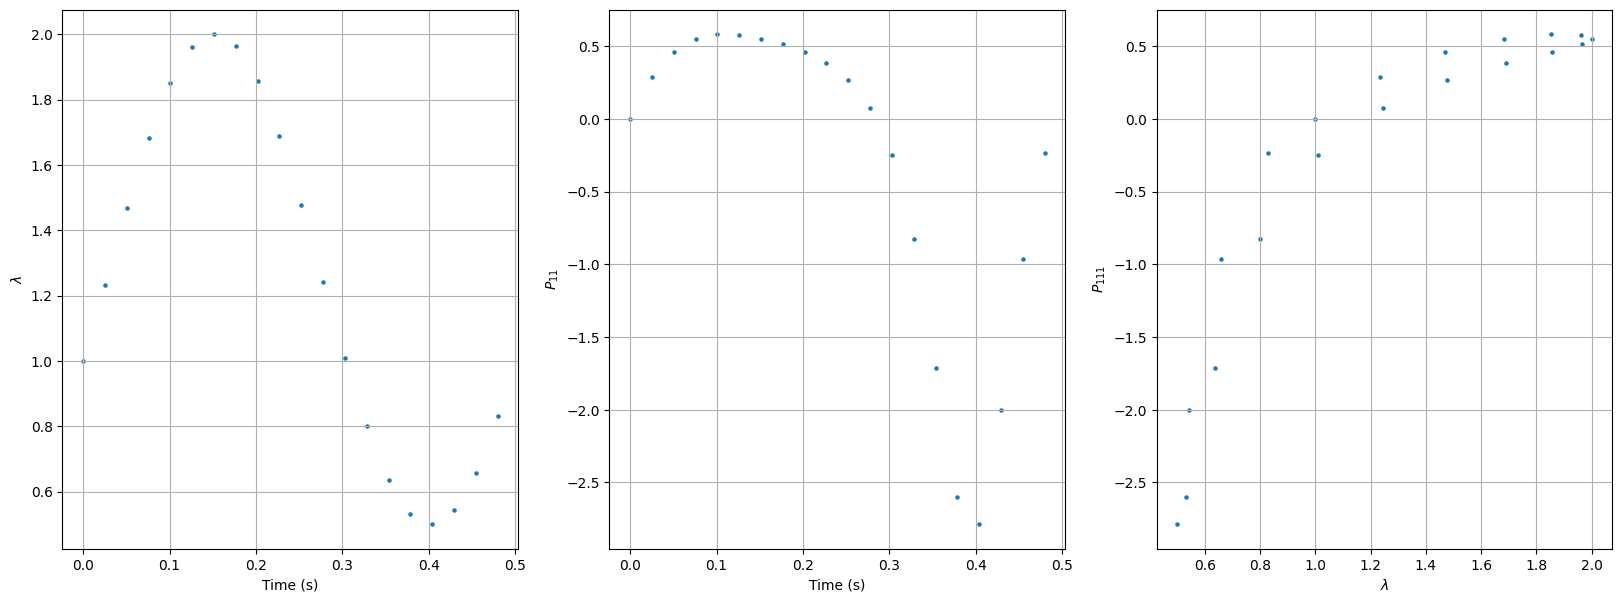

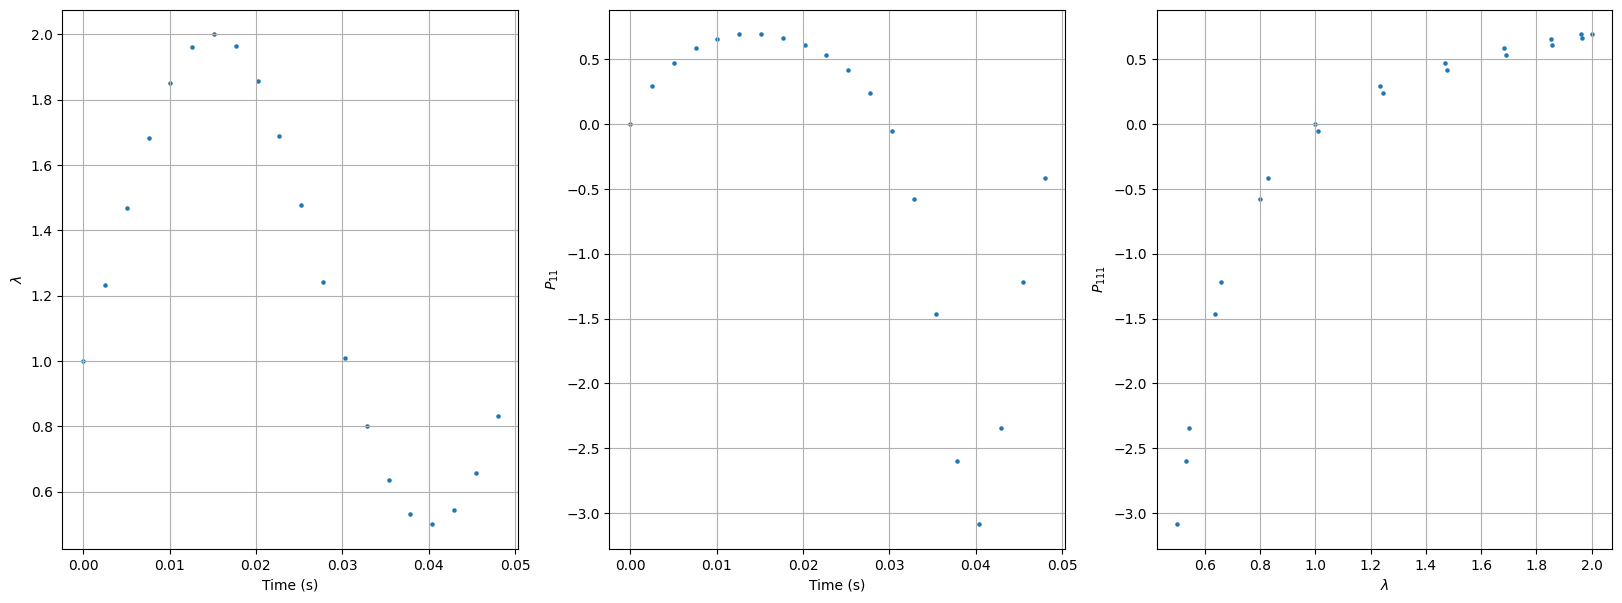

In [76]:
# Reduce the number of points
# The algo can run with much sparser data because 
# we use Backward Euler (unconditionally stable)
n = 5 # Every nth point
mdata_sparse = []
for i, (t, true_strain, true_stress) in enumerate(mdata):
    t = t[::n]
    true_strain = true_strain[::n]
    true_stress = true_stress[::n]
    mdata_sparse.append((t, true_strain, true_stress))

    # Plot nominal stress vs stretch
    stretch = np.exp(true_strain)
    P11 = true_stress/stretch
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 3, 1)
    plt.scatter(t, stretch, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$\lambda$')
    plt.grid()
    plt.subplot(1, 3, 2)
    plt.scatter(t, P11, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$P_{11}$')
    plt.grid()
    plt.subplot(1, 3, 3)
    plt.scatter(stretch, P11, s = 5)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$P_{111}$')
    plt.grid()

### Training the model

The model we use here is formulated using a mooney-rivlin type free energy for both the equilibrium and non-equilibrium parts. We can use an arbitrary number of branches for the non-equilibrium overstresses, here we use 10 branches.  
If you wish to change the number of branches, you can do it in `mat.py` by changing the num_branches in both `umri_su` and `umri_du`.  
The expression for the required stresses are:

$$\mathbf{\bar{\tau}}^e = 2(C_1 + I_1 C_2)\text{  }\mathbf{\bar{b}} - 2 C_2\text{  }\mathbf{\bar{b}}^2$$
$$(\mathbf{\bar{\tau}}^v)_i = 2\big((C_{1v})_i + (I^e_{1})_i (C_{2v})_i\big)\text{  }(\mathbf{b_e})_i - 2 (C_{2v})_i\text{  }(\mathbf{b_e})_i^2 \\ \text{for $i$ = 1 to 10}$$

For the evolution of the internal variable of each branch, we use a simple polynomial equation. We use terms upto the power of 10 for this experiment

$$\dot{\gamma} = \sum^{10}_{j=1} a_j \left( \frac{\tau_v}{\hat{\tau}} \right)^j$$  

In [77]:
# Train and Test split

# Train on the fastest and slowest experiment
mdata_train = [mdata_sparse[0], mdata_sparse[2]]

In [89]:
np.random.seed(42)
# Identifier for the model we use
mat = 'umri'

# Initialization of parameters
num_branches = 10
power_terms = 10
c1 = np.random.uniform(0.01, 0.1)
c1_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
c2 = np.random.uniform(0.01, 0.1)
c2_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
tauhinv = [1e-8 for i in range(num_branches)]
tauhinv[0] = 1
aj = [np.random.uniform(0.1, 1) for i in range(num_branches*power_terms)]
params_init = [c1] + c1_v + [c2] + c2_v + tauhinv + aj

# The names of the parameters for better readibility when outputting the results
params_names = \
    ['c1'] + [f'c1v{i}' for i in range(1, 1 + num_branches)] + \
    ['c2'] + [f'c2v{i}' for i in range(1, 1 + num_branches)] + \
    [f'tauhinv{i}' for i in range(1, 1 + num_branches)] + \
    [f'a{i}_{j}' for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]

# Use this to fix any of the parameters (A list or a single values)
fix_param = \
    [False] + [False for i in range(1, 1 + num_branches)] + \
    [False] + [False for i in range(1, 1 + num_branches)] + \
    [True for i in range(1, 1 + num_branches)] + \
    [False for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
# fix_param = False

# The parameter used for the L1 regularization
lm = 1e-2
lambda_1 = \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
# All learnable params except the one in the equilibrium branch are regularized/sparsified

In case you don't wish to go through the training, you can directly go to the evaluate part and use the saved learned parameters

Initial values
c1  : 0.04370861069626263
c1v1  : 0.09556428757689246
c1v2  : 0.07587945476302646
c1v3  : 0.0638792635777333
c1v4  : 0.02404167763981929
c1v5  : 0.02403950683025824
c1v6  : 0.015227525095137952
c1v7  : 0.08795585311974417
c1v8  : 0.0641003510568888
c1v9  : 0.0737265320016441
c1v10  : 0.011852604486622221
c2  : 0.0972918866945795
c2v1  : 0.08491983767203796
c2v2  : 0.029110519961044856
c2v3  : 0.02636424704863906
c2v4  : 0.026506405886809047
c2v5  : 0.0373818018663584
c2v6  : 0.05722807884690141
c2v7  : 0.048875051677790424
c2v8  : 0.036210622617823776
c2v9  : 0.06506676052501416
c2v10  : 0.022554447458683766
tauhinv1  : 1
tauhinv2  : 1e-08
tauhinv3  : 1e-08
tauhinv4  : 1e-08
tauhinv5  : 1e-08
tauhinv6  : 1e-08
tauhinv7  : 1e-08
tauhinv8  : 1e-08
tauhinv9  : 1e-08
tauhinv10  : 1e-08
a1_1  : 0.3629301836816964
a1_2  : 0.4297256589643226
a1_3  : 0.5104629857953323
a1_4  : 0.8066583652537123
a1_5  : 0.2797064039425238
a1_6  : 0.5628109945722505
a1_7  : 0.6331731119758383
a1_

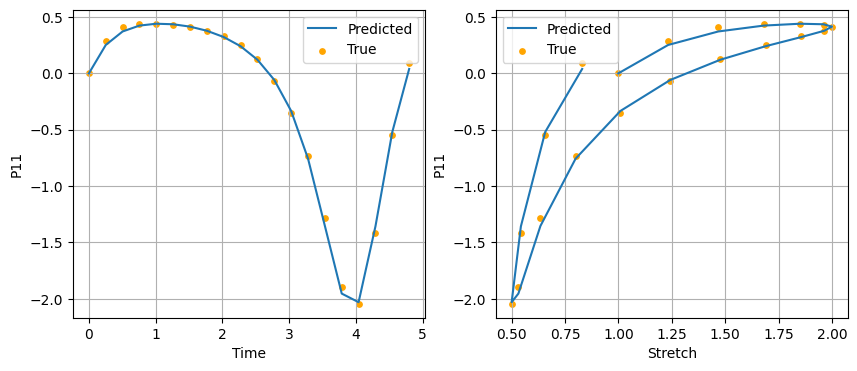

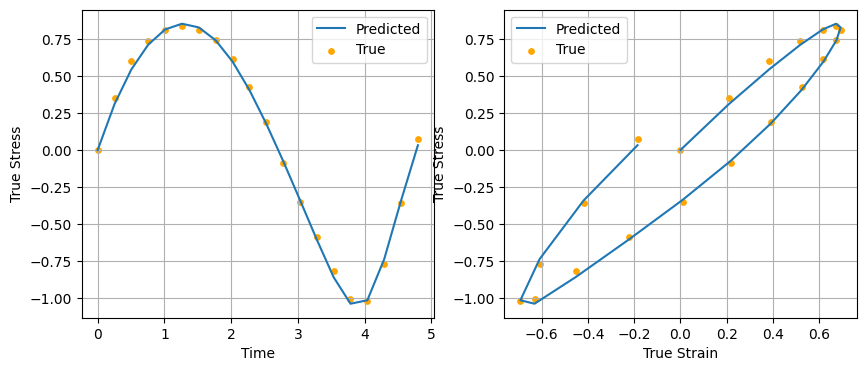


 --------------------------------- 



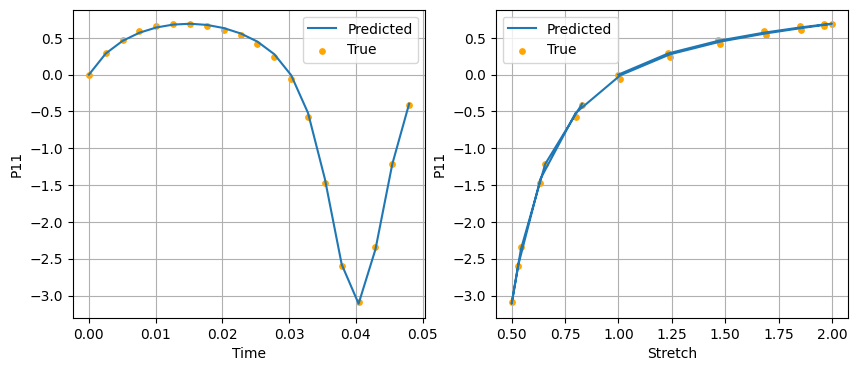

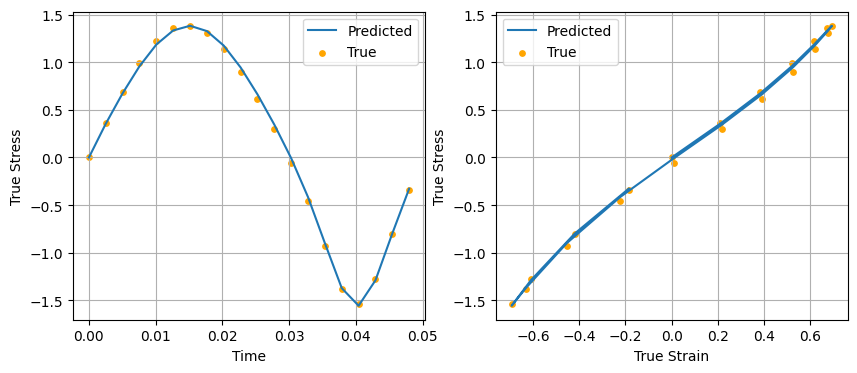

Loss:  0.0004037641540738027 

iteration number:  1009
c1  : 0.05539138965707173
c1v1  : 0.06608687083535186
c1v2  : 1e-08
c1v3  : 1e-08
c1v4  : 1e-08
c1v5  : 1e-08
c1v6  : 1e-08
c1v7  : 1e-08
c1v8  : 1e-08
c1v9  : 1e-08
c1v10  : 1e-08
c2  : 0.05903534950419662
c2v1  : 0.0994354964846788
c2v2  : 1e-08
c2v3  : 1e-08
c2v4  : 1e-08
c2v5  : 1e-08
c2v6  : 1e-08
c2v7  : 1e-08
c2v8  : 1e-08
c2v9  : 1e-08
c2v10  : 1e-08
tauhinv1  : 1
tauhinv2  : 1e-08
tauhinv3  : 1e-08
tauhinv4  : 1e-08
tauhinv5  : 1e-08
tauhinv6  : 1e-08
tauhinv7  : 1e-08
tauhinv8  : 1e-08
tauhinv9  : 1e-08
tauhinv10  : 1e-08
a1_1  : 2.019895288685209
a1_2  : 2.404018629541804
a1_3  : 2.319545649930653
a1_4  : 2.3191800622878493
a1_5  : 1.4926501687130114
a1_6  : 1.5176068189480578
a1_7  : 1.384815256630017
a1_8  : 0.7484233908049064
a1_9  : 1.1675082421712824
a1_10  : 0.7491301636504022
a2_1  : 1e-08
a2_2  : 1e-08
a2_3  : 1e-08
a2_4  : 1e-08
a2_5  : 1e-08
a2_6  : 1e-08
a2_7  : 1e-08
a2_8  : 1e-08
a2_9  : 1e-08
a2_10  : 1e-08

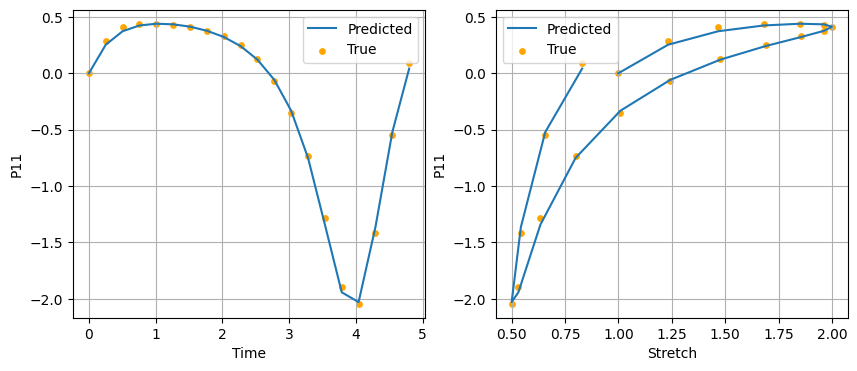

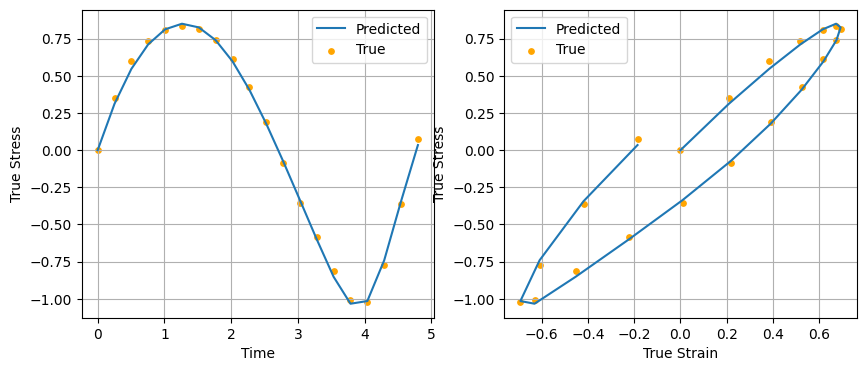


 --------------------------------- 



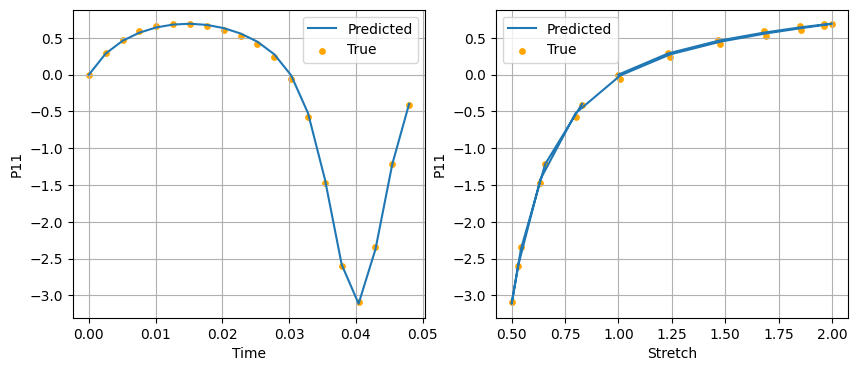

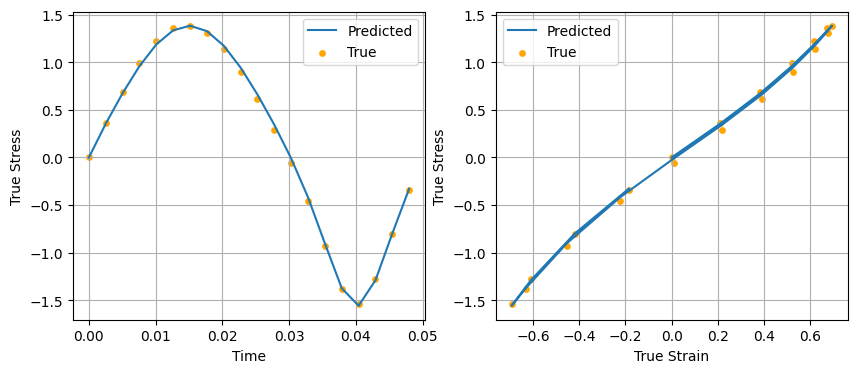

Loss:  0.00035926077638755545 

iteration number:  2009
c1  : 0.05360099421753066
c1v1  : 0.06877167414130193
c1v2  : 1e-08
c1v3  : 1e-08
c1v4  : 1e-08
c1v5  : 1e-08
c1v6  : 1e-08
c1v7  : 1e-08
c1v8  : 1e-08
c1v9  : 1e-08
c1v10  : 1e-08
c2  : 0.061346020200864694
c2v1  : 0.09660764491801925
c2v2  : 1e-08
c2v3  : 1e-08
c2v4  : 1e-08
c2v5  : 1e-08
c2v6  : 1e-08
c2v7  : 1e-08
c2v8  : 1e-08
c2v9  : 1e-08
c2v10  : 1e-08
tauhinv1  : 1
tauhinv2  : 1e-08
tauhinv3  : 1e-08
tauhinv4  : 1e-08
tauhinv5  : 1e-08
tauhinv6  : 1e-08
tauhinv7  : 1e-08
tauhinv8  : 1e-08
tauhinv9  : 1e-08
tauhinv10  : 1e-08
a1_1  : 1.8295428520586394
a1_2  : 3.279447716436135
a1_3  : 3.2379368079805566
a1_4  : 3.0031440638527345
a1_5  : 1.910916472019091
a1_6  : 1.7054857847020815
a1_7  : 1.3865224018825406
a1_8  : 0.6010811837190444
a1_9  : 0.8982520346433701
a1_10  : 0.37533932096643324
a2_1  : 1e-08
a2_2  : 1e-08
a2_3  : 1e-08
a2_4  : 1e-08
a2_5  : 1e-08
a2_6  : 1e-08
a2_7  : 1e-08
a2_8  : 1e-08
a2_9  : 1e-08
a2_10  :

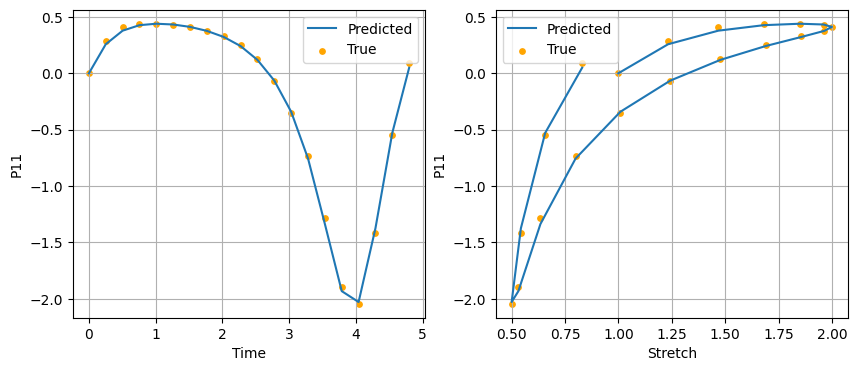

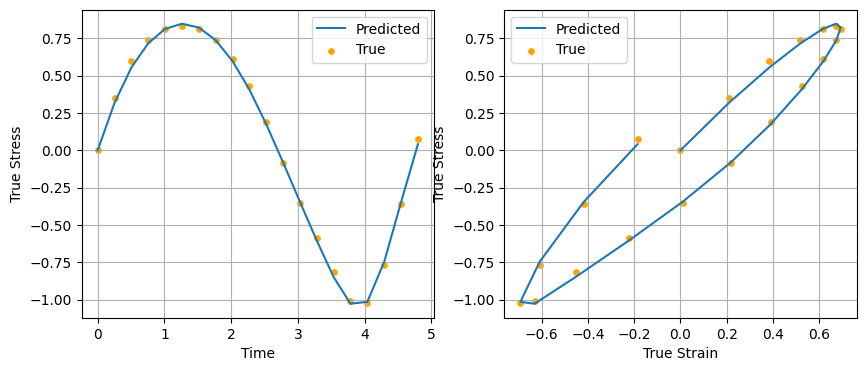


 --------------------------------- 



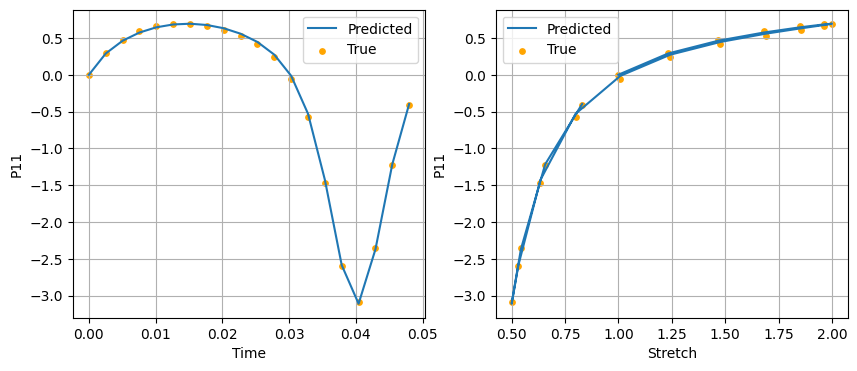

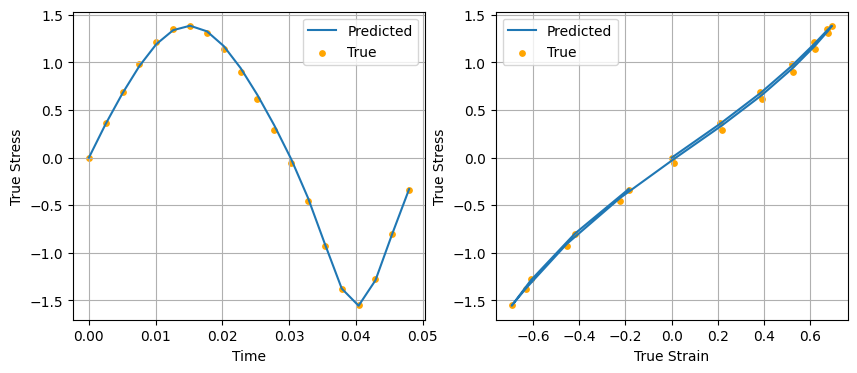



LOWEST LOSS
iteration number:  2999
c1  : 0.04932668316163862
c1v1  : 0.07497125214620251
c1v2  : 1e-08
c1v3  : 1e-08
c1v4  : 1e-08
c1v5  : 1e-08
c1v6  : 1e-08
c1v7  : 1e-08
c1v8  : 1e-08
c1v9  : 1e-08
c1v10  : 1e-08
c2  : 0.06289655895959768
c2v1  : 0.09329302593857285
c2v2  : 1e-08
c2v3  : 1e-08
c2v4  : 1e-08
c2v5  : 1e-08
c2v6  : 1e-08
c2v7  : 1e-08
c2v8  : 1e-08
c2v9  : 1e-08
c2v10  : 1e-08
tauhinv1  : 1
tauhinv2  : 1e-08
tauhinv3  : 1e-08
tauhinv4  : 1e-08
tauhinv5  : 1e-08
tauhinv6  : 1e-08
tauhinv7  : 1e-08
tauhinv8  : 1e-08
tauhinv9  : 1e-08
tauhinv10  : 1e-08
a1_1  : 1.223221327195838
a1_2  : 4.843840022902074
a1_3  : 5.147142607817195
a1_4  : 4.703762875561561
a1_5  : 3.2883645884433417
a1_6  : 2.7759867461268493
a1_7  : 2.1940043612447946
a1_8  : 1.1863093650985057
a1_9  : 1.2911739658388532
a1_10  : 0.5931809452593549
a2_1  : 1e-08
a2_2  : 1e-08
a2_3  : 1e-08
a2_4  : 1e-08
a2_5  : 1e-08
a2_6  : 1e-08
a2_7  : 1e-08
a2_8  : 1e-08
a2_9  : 1e-08
a2_10  : 1e-08
a3_1  : 1e-08
a

In [90]:
# Run the optimization
params_out, params_hist, loss_hist = \
optimize(mdata_train, params_init, params_names, mat, max_iter=3000, print_after=10, plot_after = 1000, tol=10e-6,
         alpha=1e-1, b1=0.9, b2=0.999, e=1e-8, lambda_1 = lambda_1,
         non_neg = True,
         fix_param = fix_param,
         get_lowest=True)


 --------------------------------- 



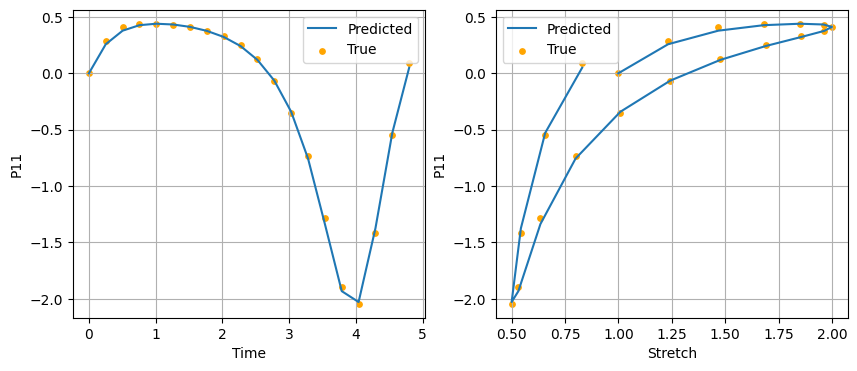

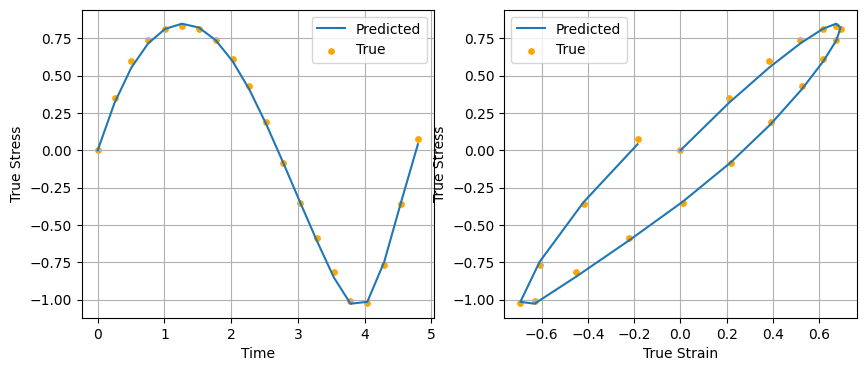


 --------------------------------- 



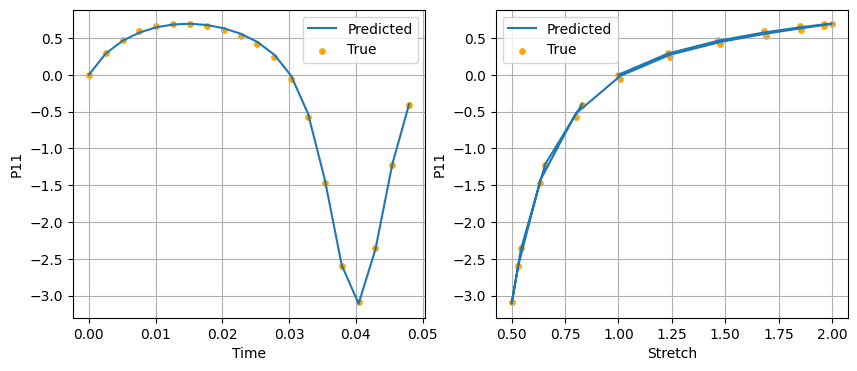

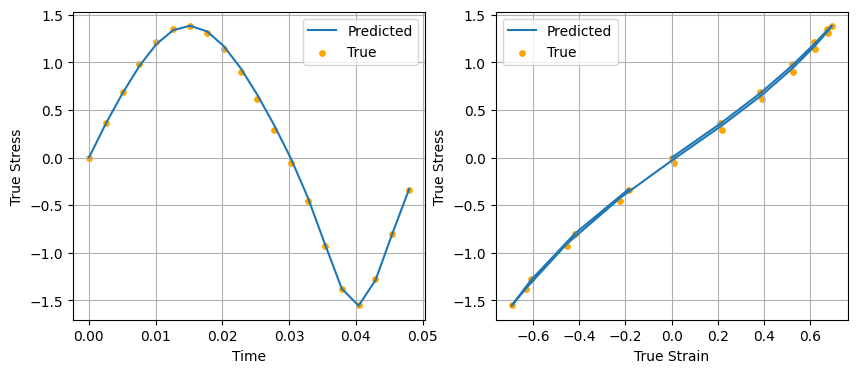

In [91]:
# Fit on the training data
L, pred = evaluate(mdata_train, params_out, mat, plot=True)

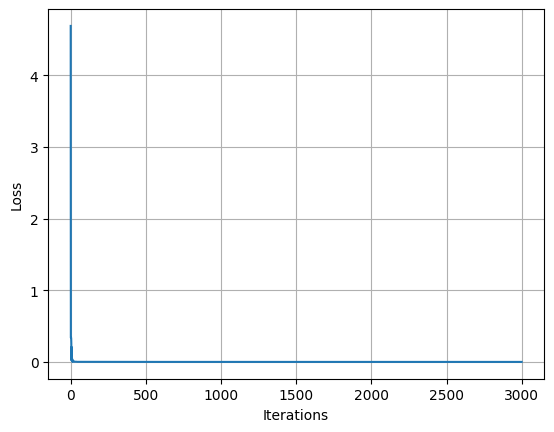

In [92]:
# Plot the loss hist
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [93]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump([params_out, params_hist, loss_hist], file)

### Evaluate the results

In [96]:
import pickle

with open('results.pkl', 'rb') as file:
    params_out, params_hist, loss_hist = pickle.load(file)
params_out = params_hist[-1]

In [97]:
print('###--NON ZERO PARAMETERS--###')

for j in range(len(params_out)):
    if params_out[j] > 1e-7:
        print(params_names[j], " :", params_out[j])

###--NON ZERO PARAMETERS--###
c1  : 0.04932061646822837
c1v1  : 0.07498024479015589
c2  : 0.06289803472044475
c2v1  : 0.09328873346999668
tauhinv1  : 1
a1_1  : 1.2223474571029247
a1_2  : 4.845874267527909
a1_3  : 5.149747224673113
a1_4  : 4.706197136919992
a1_5  : 3.290452144840409
a1_6  : 2.777726507999402
a1_7  : 2.1954365539348983
a1_8  : 1.1874740512315292
a1_9  : 1.292099822049032
a1_10  : 0.5938815884983085



 --------------------------------- 



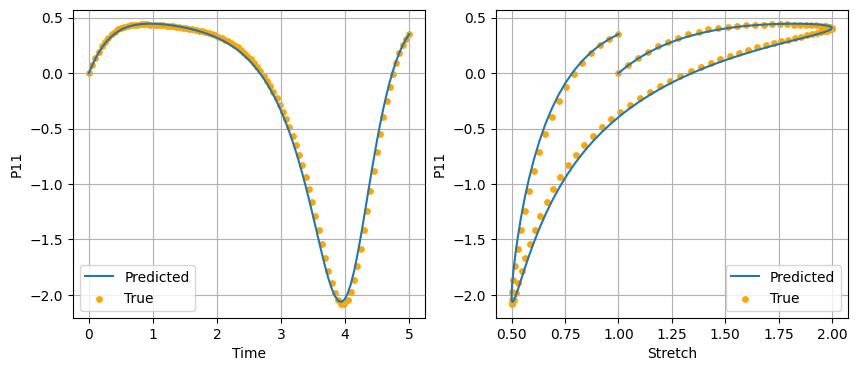

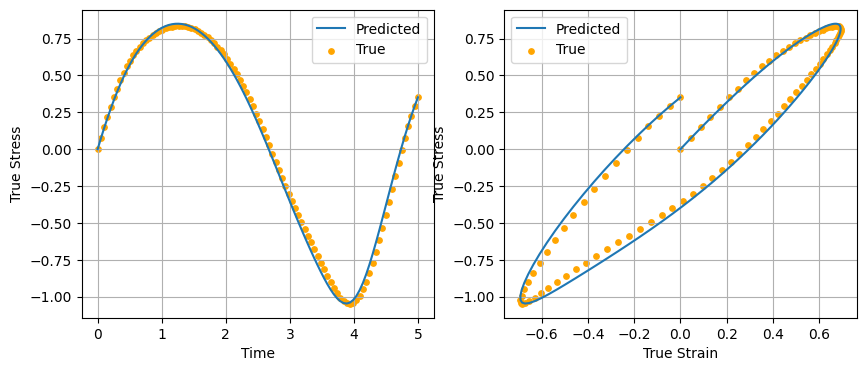


 --------------------------------- 



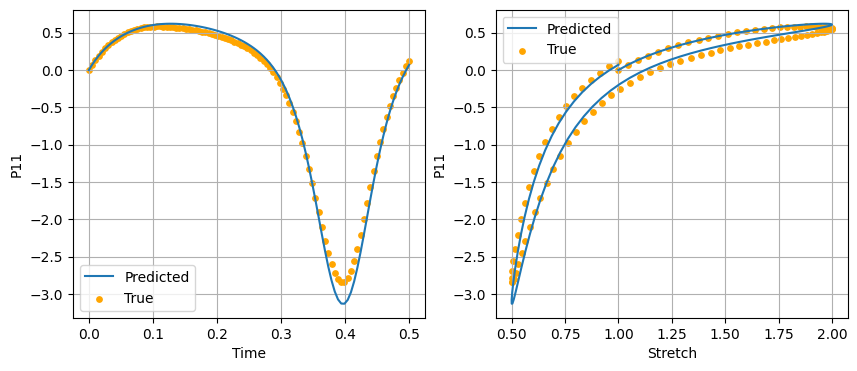

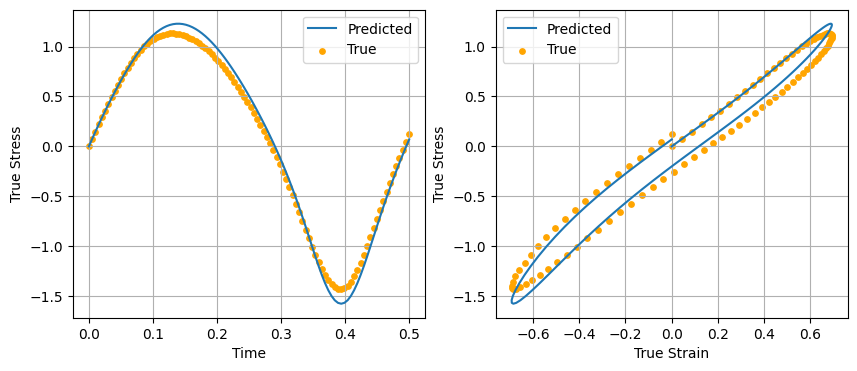


 --------------------------------- 



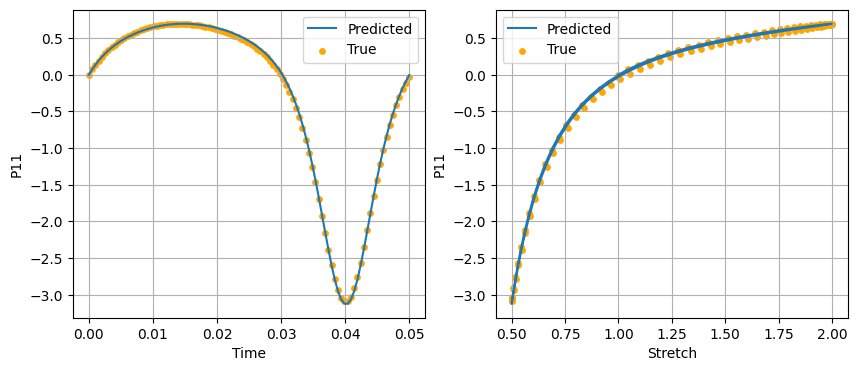

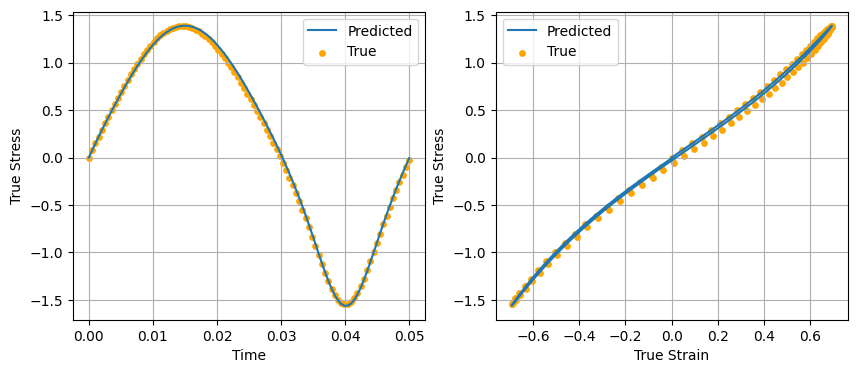

In [98]:
L, pred = evaluate(mdata, params_out, mat, plot=True)